In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
from scipy import signal

from filters import AdaptiveEqualizerAlamouti, CDCompensator, PulseFilter
from modulation import Demodulator16QAM, Modulator16QAM
from receiver import Digital90degHybrid
from utils import normalize_power

In [3]:
def plot_signal(signal: np.ndarray, alpha=1.0, size=0.1) -> None:
    assert signal.ndim == 1
    assert signal.size > 0

    s_real = np.real(signal[:8192])
    s_imag = np.imag(signal[:8192])

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 6))

    # Constellation diagram.
    ax = axs[0][0]
    ax.scatter(s_real, s_imag, alpha=alpha, s=size)
    ax.axis("equal")
    ax.set_xlabel("In-phase")
    ax.set_ylabel("Quadrature")
    ax.axhline(color="black")
    ax.axvline(color="black")

    # Unused plot.
    axs[1][0].set_axis_off()

    # Signal (real component).
    ax = axs[0][1]
    ax.stem(s_real)
    ax.set_xlim(-4, 128)
    ax.set_xlabel("Sample")
    ax.set_ylabel("In-phase")

    # Signal (imaginary component).
    ax = axs[1][1]
    ax.stem(s_imag)
    ax.set_xlim(-4, 128)
    ax.set_xlabel("Sample")
    ax.set_ylabel("Quadrature")

    # Spectrum.
    axs[0][2].magnitude_spectrum(signal.tolist(), sides="twosided")
    axs[1][2].phase_spectrum(signal.tolist(), sides="twosided")

    fig.tight_layout()

    plt.show()

In [4]:
# 256 GSa/s, stored as 16-bit signed integers
data_256i = np.ravel(
    scipy.io.loadmat("data_bence_paper/capture_50G_run6_-20dBm.mat")["ch1"]
)

# Convert to cdouble, and normalize power
# NOTE the mean is not 0, but subtracting it did not help at all
data_256d = data_256i.astype(np.cdouble)
data_256d = normalize_power(data_256d)

# Reference data
data_ref = np.ravel(scipy.io.loadmat("data_alamouti/AC_data.mat")["s_qam"])
data_ref /= np.sqrt(10)
data_ref.size

32768

In [5]:
sx2 = np.ravel(scipy.io.loadmat("data_alamouti/AC_data.mat")["sx2"])
sy2 = np.ravel(scipy.io.loadmat("data_alamouti/AC_data.mat")["sy2"])

In [6]:
qpsk_sync = np.ravel(scipy.io.loadmat("data_alamouti/QPSK_sync.mat")["s"])
qpsk_sync.size

1024

In [7]:
so = normalize_power(np.ravel(scipy.io.loadmat("data_alamouti/AC_data.mat")["so"]))
so.size

16384

In [8]:
se = normalize_power(np.ravel(scipy.io.loadmat("data_alamouti/AC_data.mat")["se"]))
se.size

16384

In [9]:
assert np.allclose(sx2[:1024], qpsk_sync)
assert np.allclose(sy2[:1024], qpsk_sync)
assert np.allclose(sx2[1024:2048], qpsk_sync)
assert np.allclose(sy2[1024:2048], qpsk_sync)

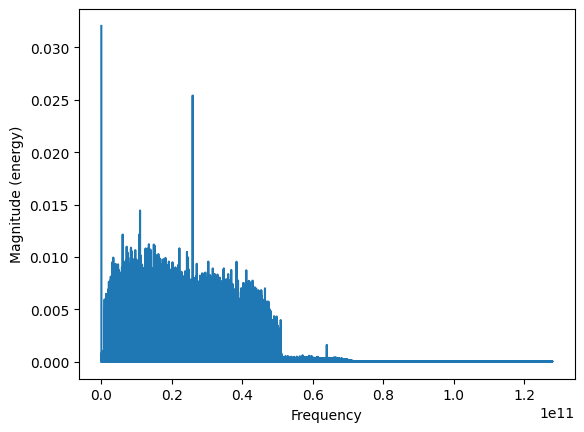

In [10]:
plt.magnitude_spectrum(data_256d.real.tolist(), Fs=256e9)
plt.show()

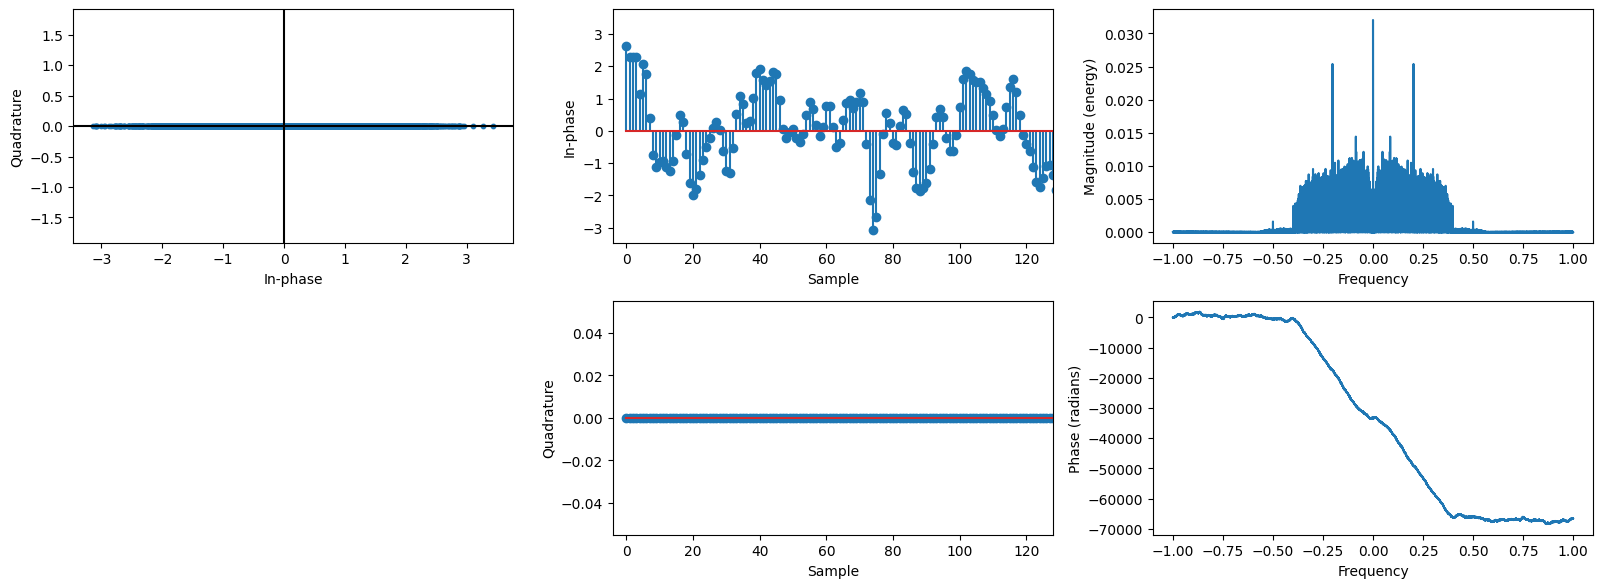

In [11]:
plot_signal(data_256d, size=10)

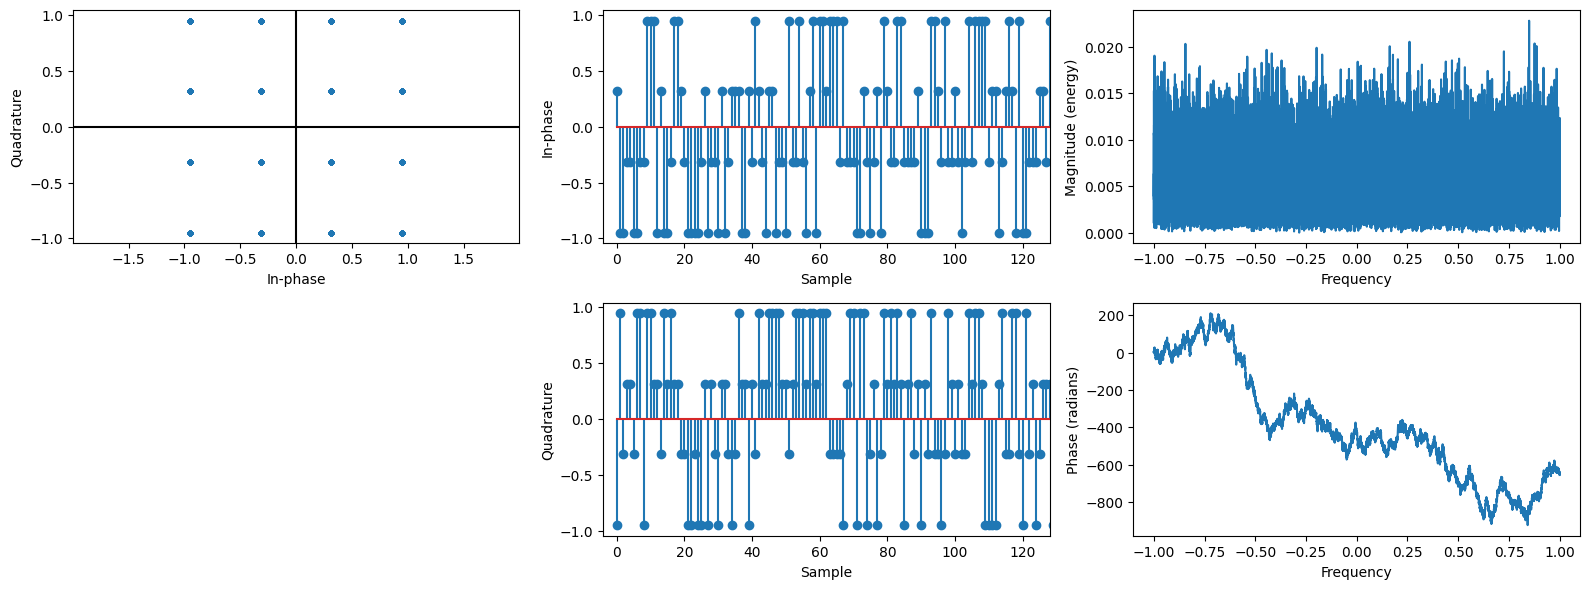

In [12]:
plot_signal(data_ref, size=10)

In [13]:
# Peak in the spectrum is the IF
np.fft.fftfreq(data_256d.size, d=1 / 256e9)[
    np.argmax(np.abs(np.fft.fft(data_256d)))
] / 1e9

0.0

In [14]:
spectrum = np.abs(np.fft.fft(data_256d))
freqs = np.fft.fftfreq(data_256d.size, d=1 / 256e9)

# Erase peaks outside the 26 GHz region.
spectrum[freqs < 24e9] = 0

freqs[np.argmax(spectrum)] / 1e9

25.92494933333333

In [15]:
# XXX Do this first before resampling to 100 GS/s. Note that this IF is not
# negative, unlike what we found when resample first!
rx_if = Digital90degHybrid(25.925, 256e9)(data_256d)

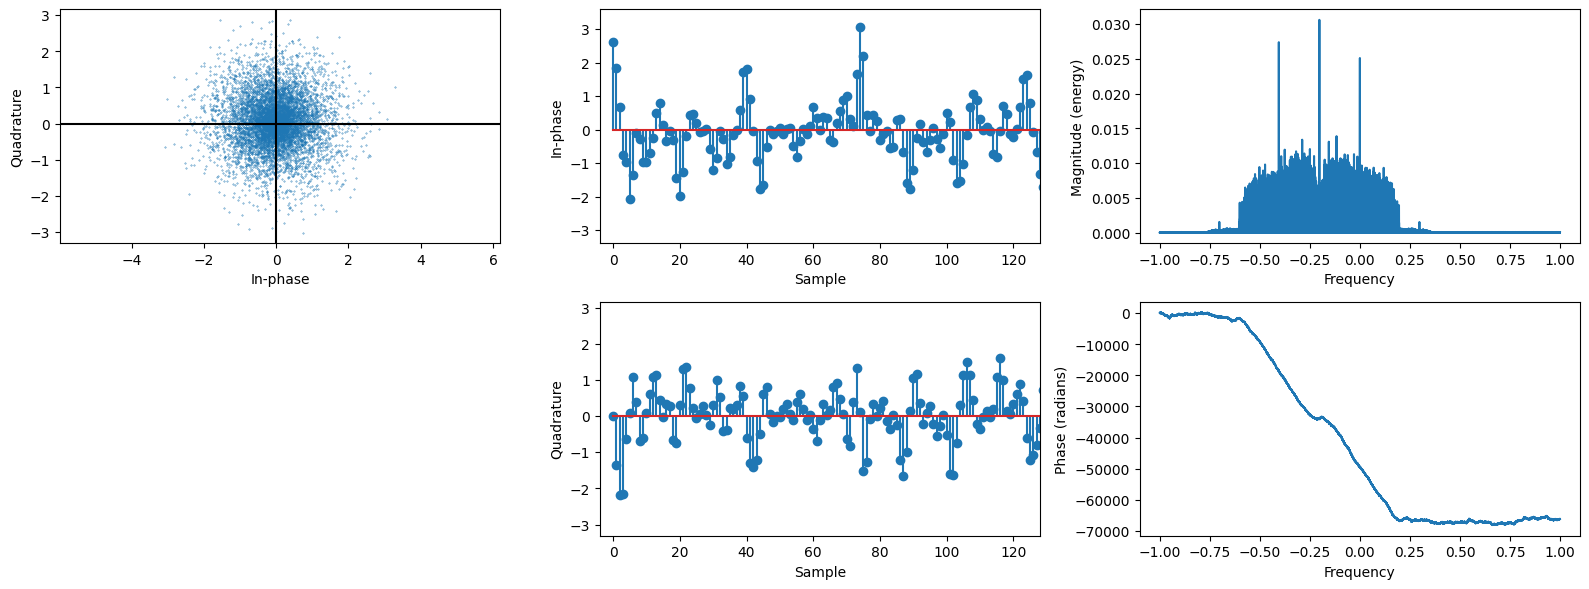

In [16]:
plot_signal(rx_if)

In [17]:
# Resample to 100 GSa/s (2 SpS)
data_100 = scipy.signal.resample_poly(rx_if, up=25, down=64)
data_100.shape

(585938,)

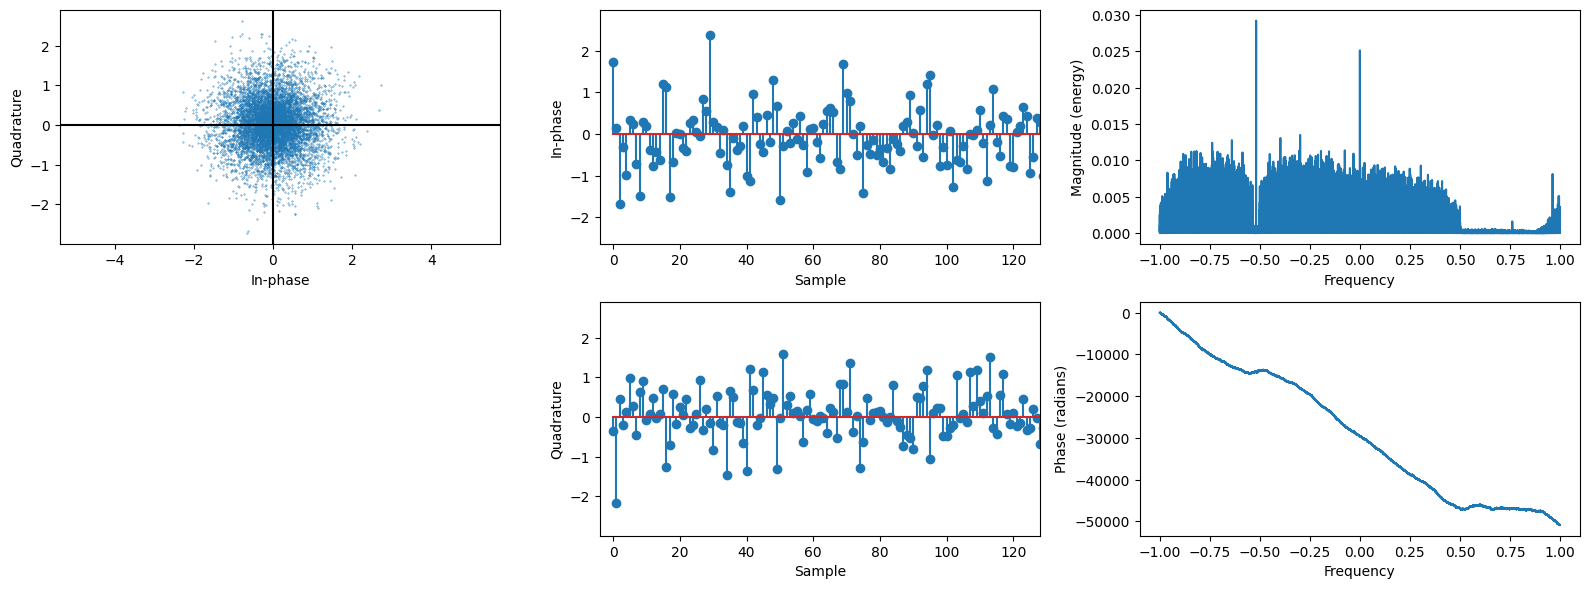

In [18]:
plot_signal(data_100)

In [46]:
# 25 km of fibre.
rx_cd = CDCompensator(25_000, 100e9, 2, 299, 0.01)(data_100)

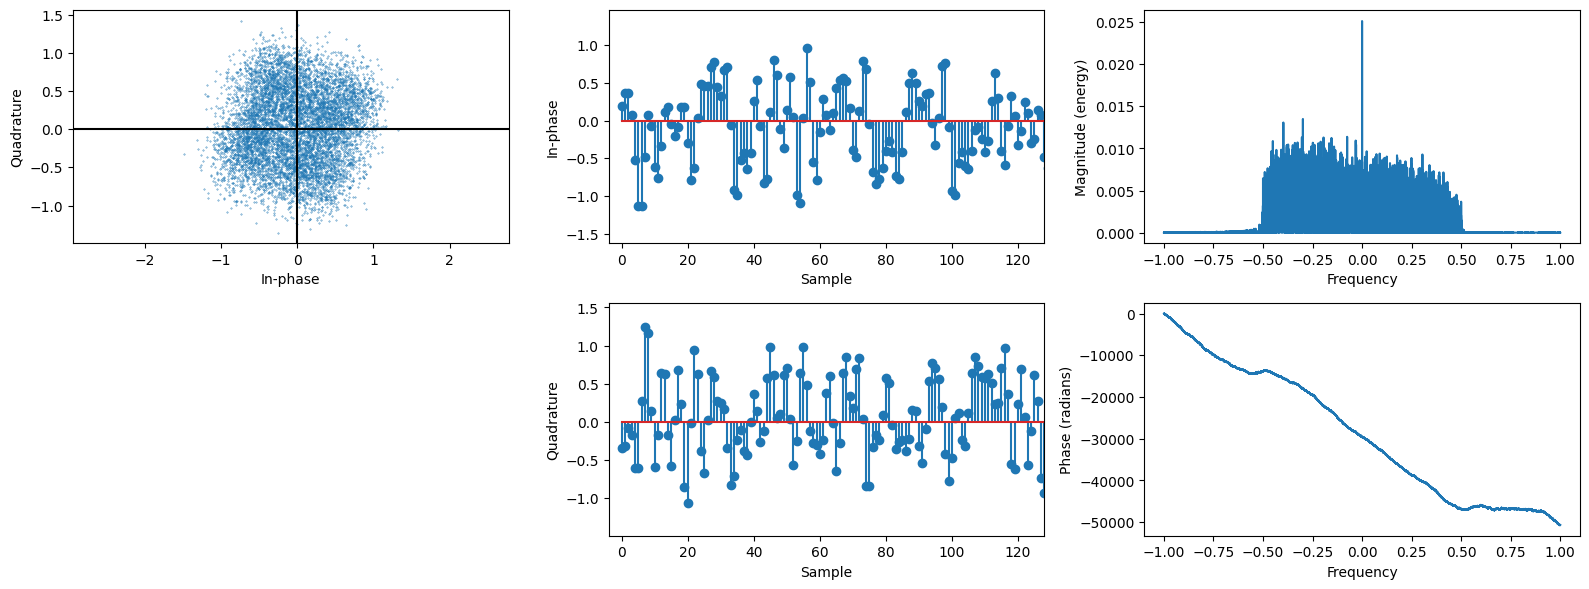

In [47]:
plot_signal(rx_cd)

In [48]:
pf = PulseFilter(2, down=1)
pf.BETA = 0.01
pf.SPAN = 508
rx_pf = pf(rx_cd)

In [49]:
assert pf.impulse_response.size == 1016

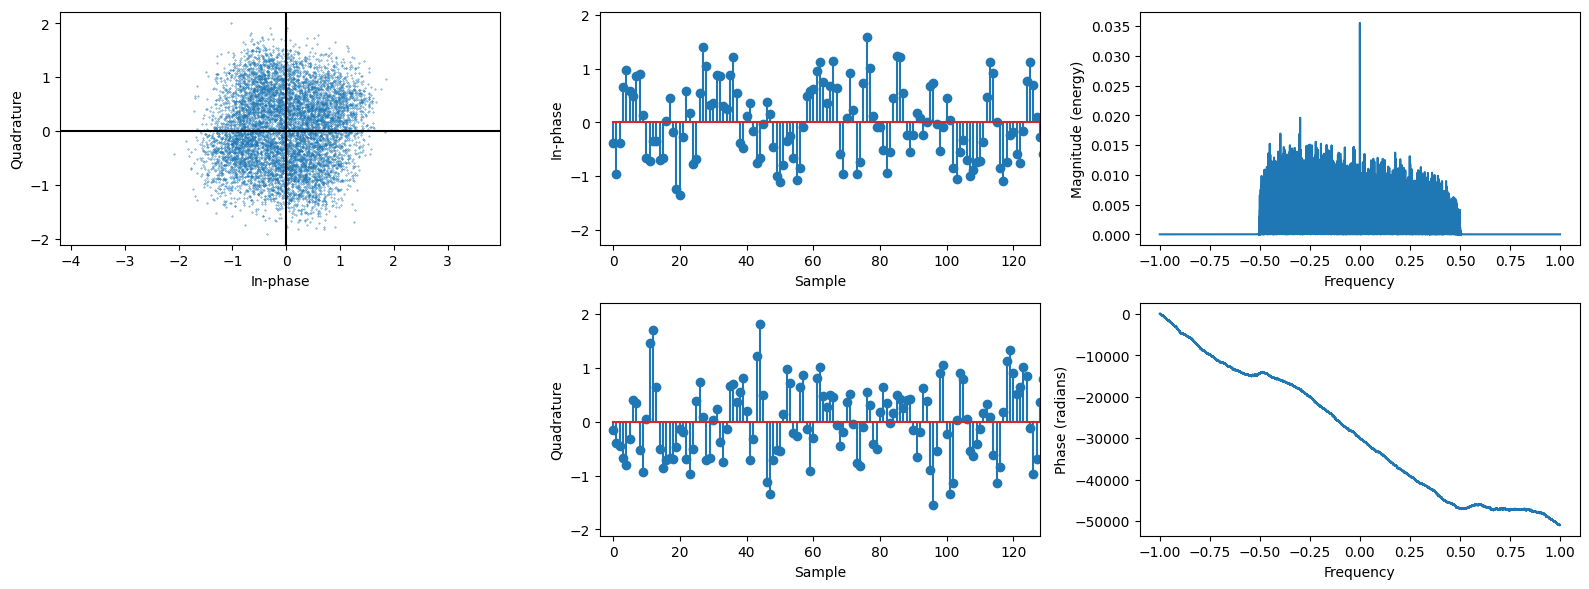

In [50]:
plot_signal(rx_pf)

In [51]:
def find_lag(ref: np.ndarray, sig: np.ndarray) -> int:
    corr = np.abs(signal.correlate(ref, sig))
    lags = signal.correlation_lags(ref.size, sig.size)
    plt.plot(lags, corr)
    plt.show()
    lag = lags[np.argmax(corr)]
    return lag

In [52]:
def find_all_lags(ref: np.ndarray, sig: np.ndarray, threshold: float) -> int:
    corr = np.abs(signal.correlate(ref, sig))
    lags = signal.correlation_lags(ref.size, sig.size)
    lag = lags[corr > threshold]
    return lag

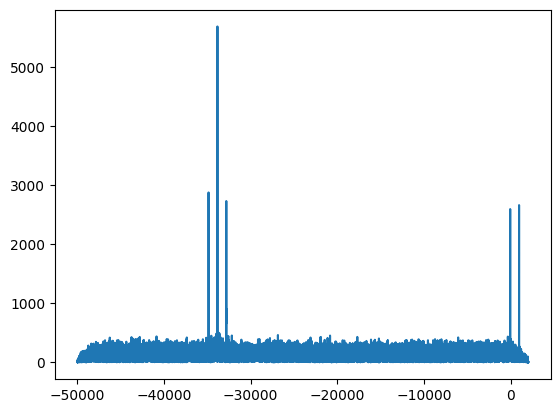

-33835

In [53]:
find_lag(np.conj(np.tile(qpsk_sync, 2)), rx_pf[0:100_000:2])

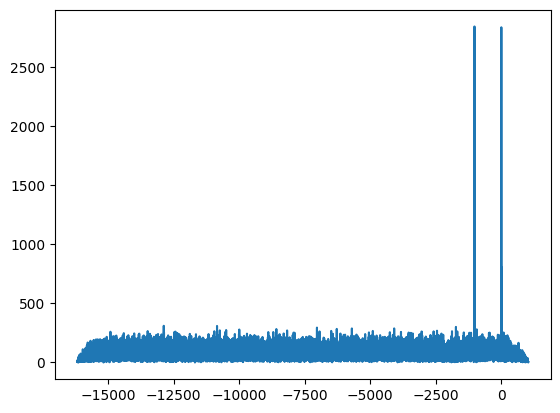

-1029

In [54]:
# qpsk_sync leads rx_pf by 13652 samples
# find_lag(qpsk_sync, rx_pf[2 * 13652 - 2048 : 2 * 50_000 : 2])
find_lag(np.conj(qpsk_sync), rx_pf[2 * 33830 : 2 * 50_000 : 2])

In [55]:
all_lags = find_all_lags(qpsk_sync, rx_pf[::2], 500)
all_lags

array([], dtype=int64)

In [56]:
np.diff(all_lags)

array([], dtype=int64)

In [57]:
rx_sync = rx_pf[2 * 33830 : -3]
rx_sync.shape

(517260,)

In [58]:
np.diff(find_all_lags(qpsk_sync, rx_sync[::2], 500))

array([], dtype=int64)

In [59]:
2 * qpsk_sync.size + data_ref.size

34816

In [60]:
rx_16qam = normalize_power(
    rx_sync[np.mod(np.arange(rx_sync.size), 2 * 34816) >= 2 * 2 * 1024]
)[: 2 * 32768]
rx_16qam = np.tile(rx_16qam, 20)
rx_16qam.size

1310720

In [61]:
training = np.tile(normalize_power(data_ref), 20)
training.size

655360

In [62]:
assert rx_16qam.size == 2 * training.size

In [71]:
aeq = AdaptiveEqualizerAlamouti(
    149, 1e-3, 0.1, Modulator16QAM(), Demodulator16QAM(), training, True
)

rx_aeq = aeq(rx_16qam)

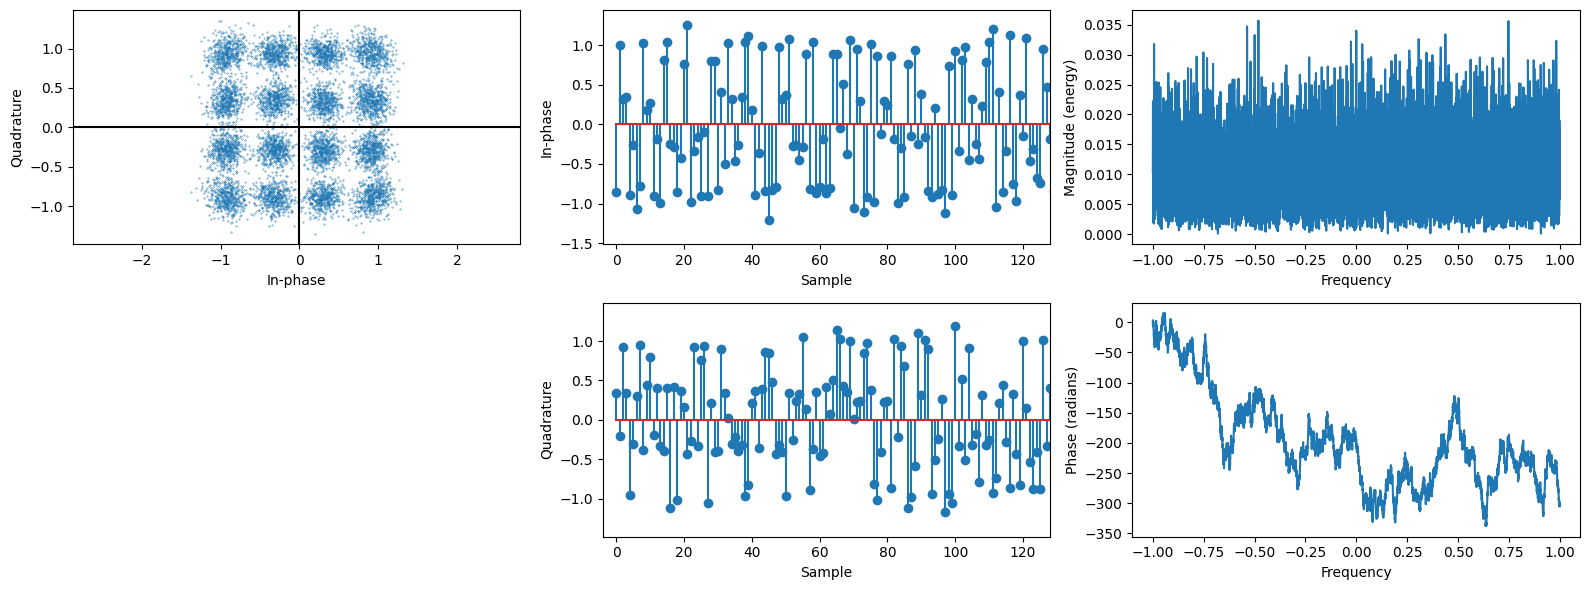

In [72]:
plot_signal(rx_aeq[315_000:325_000])

In [73]:
np.mean(
    Demodulator16QAM()(training[10000 : rx_aeq.size])
    != Demodulator16QAM()(rx_aeq[10000:])
)

0.008287622412297012

In [74]:
np.mean(
    Demodulator16QAM()(training[315000:325000])
    != Demodulator16QAM()(rx_aeq[315000:325000])
)

0.006175

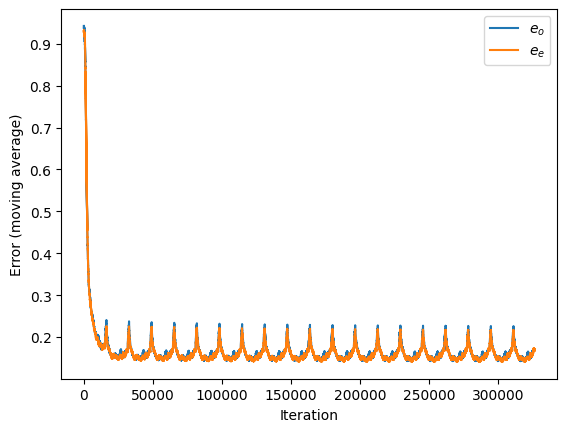

In [75]:
def ma(x, w):
    return np.convolve(x, np.ones(w), "valid") / w


plt.plot(ma(np.abs(aeq.e_oC_log), 1_000), label="$e_o$")
plt.plot(ma(np.abs(aeq.e_eC_log), 1_000), label="$e_e$")
plt.ylabel("Error (moving average)")
plt.xlabel("Iteration")
plt.legend()
plt.show()

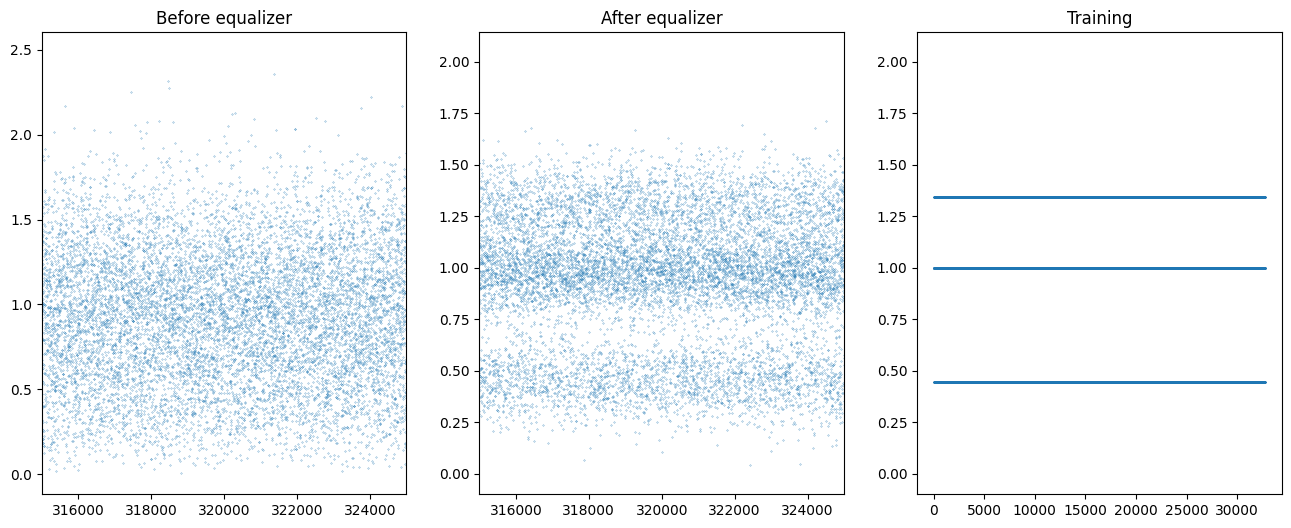

In [76]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].scatter(range(rx_16qam.size), np.abs(rx_16qam), s=0.05)
axs[0].set_title("Before equalizer")
axs[1].scatter(range(rx_aeq.size), np.abs(rx_aeq), s=0.05)
axs[1].set_title("After equalizer")
axs[2].scatter(range(data_ref.size), np.abs(data_ref), s=0.05)
axs[2].set_title("Training")
axs[2].set_ylim(*axs[1].get_ylim())
axs[0].set_xlim(315000, 325000)
axs[1].set_xlim(315000, 325000)
plt.show()

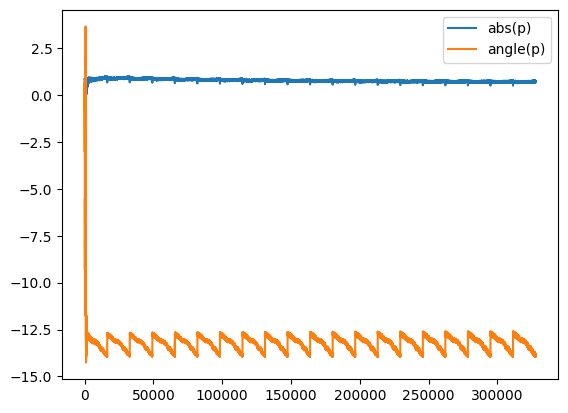

In [77]:
plt.plot(np.abs(aeq.p_log), label="abs(p)")
plt.plot(np.unwrap(np.angle(aeq.p_log)), label="angle(p)")
plt.legend()
plt.show()

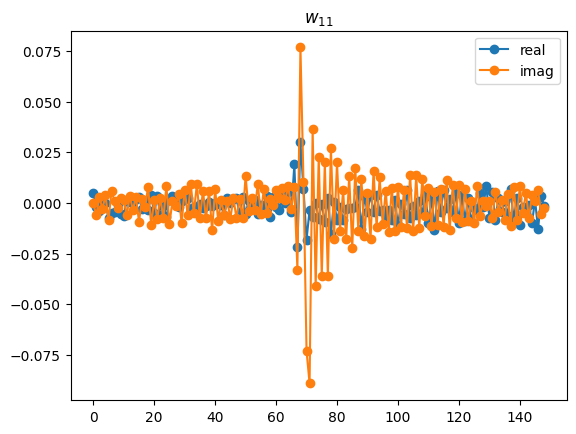

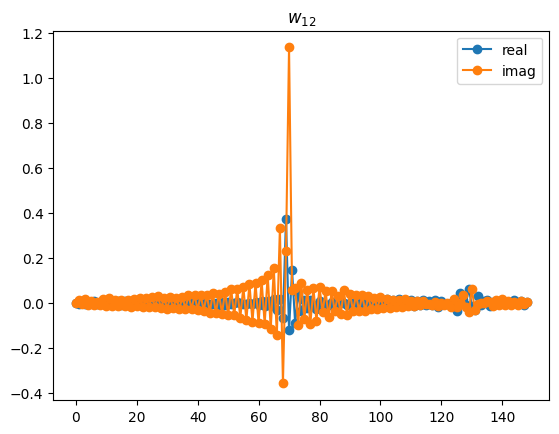

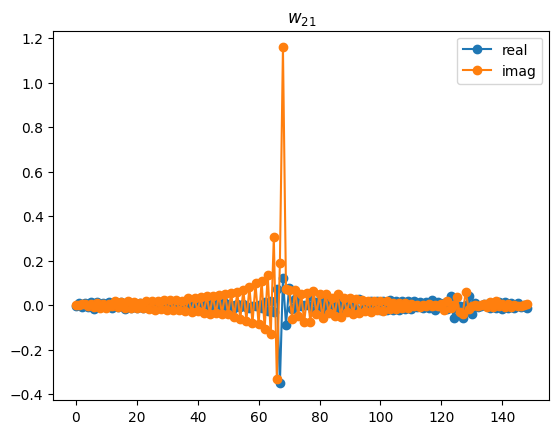

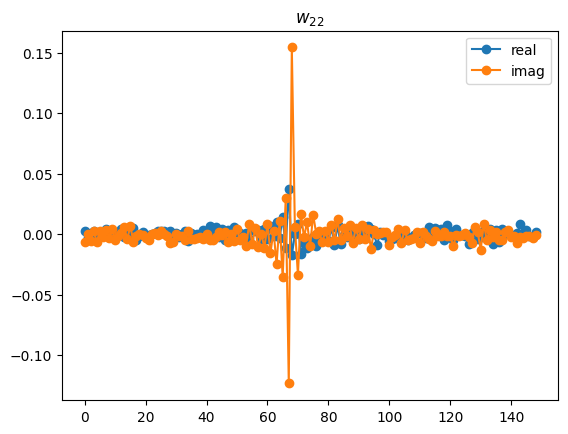

In [78]:
plt.plot(np.real(aeq.w11), "o-", label="real")
plt.plot(np.imag(aeq.w11), "o-", label="imag")
plt.title("$w_{11}$")
plt.legend()
plt.show()
plt.plot(np.real(aeq.w12), "o-", label="real")
plt.plot(np.imag(aeq.w12), "o-", label="imag")
plt.title("$w_{12}$")
plt.legend()
plt.show()
plt.plot(np.real(aeq.w21), "o-", label="real")
plt.plot(np.imag(aeq.w21), "o-", label="imag")
plt.title("$w_{21}$")
plt.legend()
plt.show()
plt.plot(np.real(aeq.w22), "o-", label="real")
plt.plot(np.imag(aeq.w22), "o-", label="imag")
plt.title("$w_{22}$")
plt.legend()
plt.show()

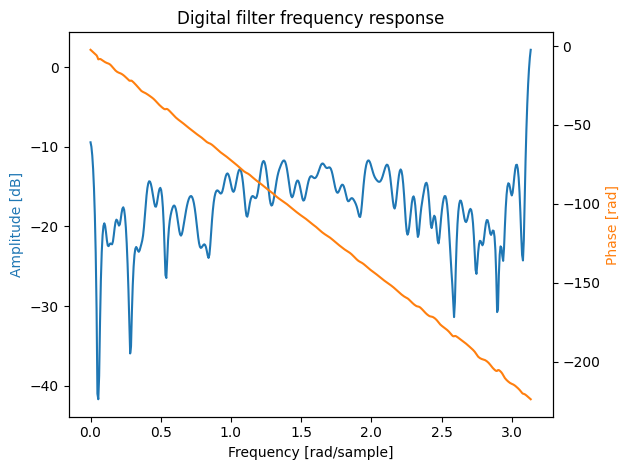

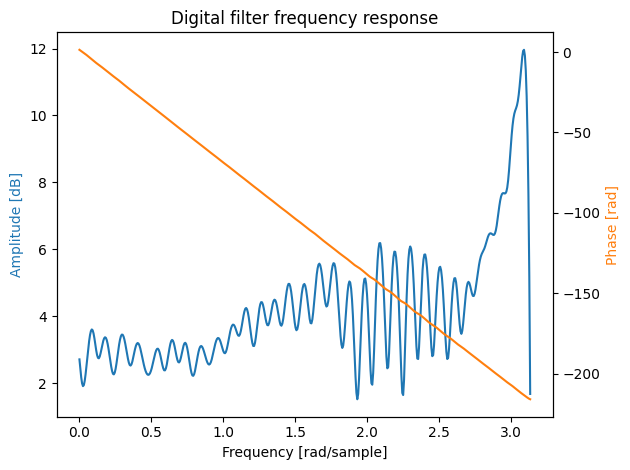

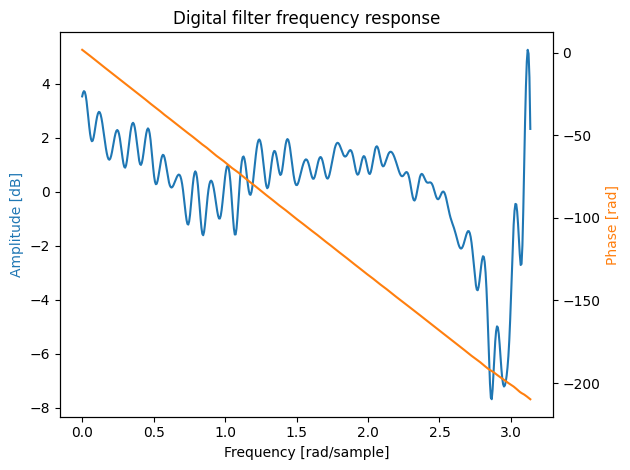

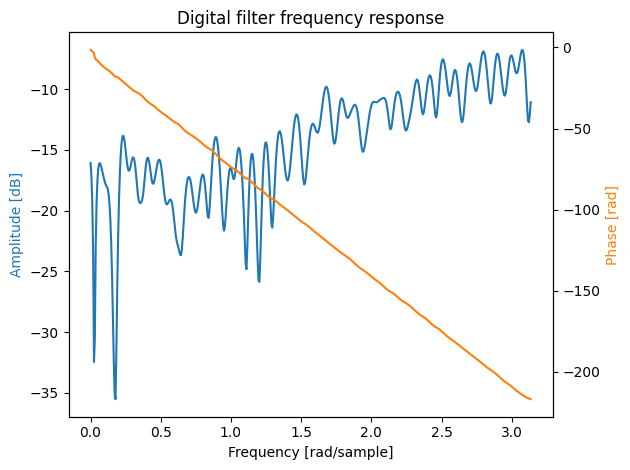

In [79]:
from utils import plot_filter

plot_filter(aeq.w11)
plot_filter(aeq.w12)
plot_filter(aeq.w21)
plot_filter(aeq.w22)